# Sequence Creation and Validation

*What you will learn:*

- what a Pulser `Sequence` is;
- what you can do with a `Sequence`;
- how to make sure your `Sequence` is valid.

## The Pulser `Sequence`

The `Sequence` is what encapsulates a Pulser program and it brings together all the concepts we have introduced so far in the *Fundamentals* section. Concretely, a `Sequence` combines:

- a [Register](register.ipynb) that defines the relative positions of the atoms involved in the computation;
- a [Device](hardware.ipynb#The-Device) that dictates the physical constraints the program must respect;
- [Channels](hardware.ipynb#The-Channels), selected from the `Device`, that define which states are used in the computation;
- a schedule of operations, wherein [Pulses](pulses.ipynb) are included, that determine what happens over time.

As described in [Programming a Neutral-Atom QPU](programming.md) and exemplified in the [Tutorial: ](tutorials/creating.nblink), constructing a `Sequence` is akin to programming a [time-dependent Hamiltonian](programming.md#hamiltonian-evolves-the-state). This program can then be given to a [Backend](tutorials/backends.nblink) that will evolve an initial state according to the programmed Hamiltonian, producing a result.

The pages linked above covered the step-by-step process of constructing a `Sequence`. In this page, we will instead highlight the most relevant capabilities of the `Sequence` object itself.

## Fundamental `Sequence` Capabilities

In this section, we focus only on the fundamental features for programming a sequence in Pulser.

<div class="alert alert-info">

See Also
    
All the `Sequence` properties and methods can be found in [its API reference](apidoc/_autosummary/pulser.sequence.Sequence.rst).

</div>

### Building

These four method are all you need to build a basic Pulser `Sequence`. As shown in [this tutorial](tutorials/creating.nblink), they should be used in this order:

1. Pick a channel from the `Device` and declare it with `Sequence.declare_channel()`.
2. Add pulses and delays to the channel with `Sequence.add()` and `Sequence.delay()`.
3. Terminate the sequence with `Sequence.measure()`.

<div class="alert alert-info">

Tip
    
For more details on each of these methods, click on them in the table above.

</div>

### Inspecting

During and after the sequence building process, you migh want to inspect or access its contents. These properties and methods allow you to do so:

#### Drawing and Printing

In particular, it is often useful to visualize a `Sequence`'s contents, which we can do either by **drawing** or **printing**. 
Let's exemplify these two options with the very simple sequence in [this tutorial](tutorials/creating.nblink#Preparing-an-atom-in-the-Rydberg-state).

Channel: rydberg_global
t: 0 | Initial targets: q0 | Phase Reference: 0.0 
t: 0->1000 | Pulse(Amp=3.14 rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: q0




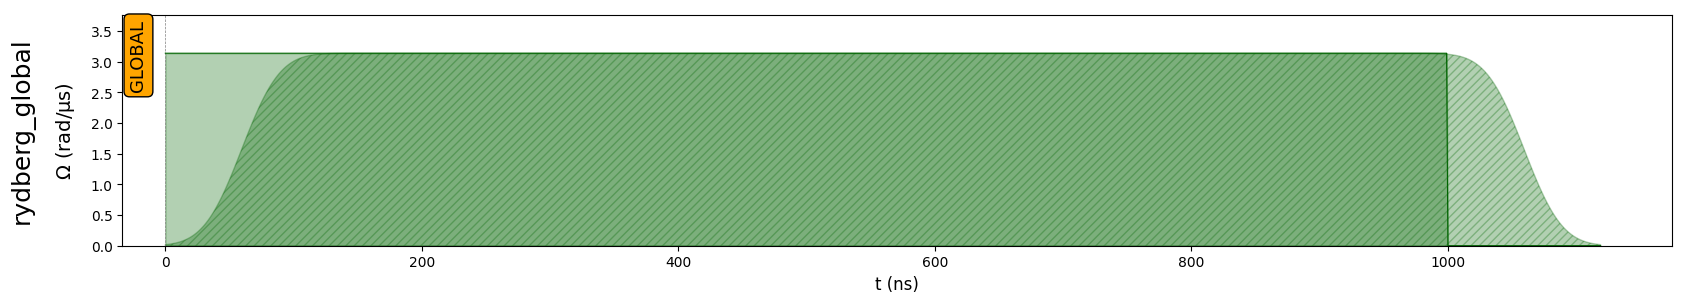

In [10]:
import pulser

sequence = pulser.Sequence(
    pulser.Register({"q0": (0, 0)}), pulser.AnalogDevice
)
sequence.declare_channel("rydberg_global", "rydberg_global")
pulse = pulser.Pulse.ConstantPulse(1000, 3.14, 0, 0)
sequence.add(pulse, "rydberg_global")

print(sequence)
sequence.draw()

- With `print(sequence)`, we have access to its contents in text form. This is particularly useful to access the exact timings of each instruction. 

<div class="alert alert-info">

Tip

To get the text representation of a sequence as a string, e.g. for saving it to a file, call `str(sequence)` instead.

</div>


- With `sequence.draw()`, we see a plot of the channel's contents over time. This method is [highly configurable](apidoc/_autosummary/pulser.sequence.Sequence.rst#pulser.sequence.Sequence.draw), though most of its options are related to features we have not yet covered.

<div class="alert alert-info">

**Understanding** `Sequence.draw()`:

You might have noticed that **two overlapping curves appear when you draw the** `Sequence`. These represent the pulse you programmed (shaded in solid color) and the *modulated pulse* we expect to actually reach the atoms (hashed with diagonal lines). You can find an explation for this effect and its implications in [this tutorial](tutorials/output_mod_eom.nblink).

</div>

  

## Runtime Validation

Alongside containing all the information necessary for execution on a backend, the `Sequence`'s main function is to ensure that all its contents respect the [Device specifications](hardware.ipynb).

Here is an example: 

- `pulser.AnalogDevice` has a defined `min_atom_distance`, a minimum distance that must be respected between any two atoms in a register;
- if we create a `Register` where two atoms are closer than this distance, it will not respect the device's constraints;
- therefore, once they are both given to the `Sequence` it will complain right away, giving us a chance to modify our register or choose a new device before we proceed with the `Sequence` creation.

In [3]:
import pulser

spacing = 2  # The spacing we will use between atoms
reg = pulser.Register({"q0": (0, 0), "q1": (spacing, 0)})

# spacing is below the AnalogDevice's specs, so we expect an error
assert spacing < pulser.AnalogDevice.min_atom_distance

try:
    pulser.Sequence(reg, pulser.AnalogDevice)
except ValueError as e:
    print("Failed with error: ", e)

Failed with error:  The minimal distance between atoms in this device (5 µm) is not respected (up to a precision of 1e-6 µm) for the pairs: [('q0', 'q1')]


<div class="alert alert-info">

Important
    
This automatic validation occurs upon every addition to the `Sequence` so that, if something is invalid, it is caught and corrected right away. By the same token, **if a Sequence is constructed without any errors, it is automatically ensured to be valid against the chosen device's constraints**.

</div>

### Switching the device

This method attemps to automatically reconstruct the sequence with the new device, which will only succeed if the new sequence is valid on the new device. 

<div class="alert alert-warning">

Attention
    
This switch may modify the contents of the `Sequence` — to ensure the contents stay unchanged, set `strict=True`.

</div>

### Backend-specific validation

There are a handful of backend-specific constraints that are not enforced during sequence construction. This is because execution on a [QPU enforces additional restrictions](tutorials/backends.nblink#1.2.-Preparation-for-execution-on-QPUBackend) that don't directly affect the programmed Hamiltonian, so they are not enforced by default. Nonetheless, **when using an emulator to fully mimic the QPU execution process, all the QPU constraints can be enabled via the** `mimic_qpu` **argument**.